# Feature matching using LoFTR 

Firstly, we resolve imports 

In [8]:
import os
import rasterio
from rasterio.plot import reshape_as_image
import cv2
import matplotlib.pyplot as plt
import torch
import kornia as K
from kornia_moons.viz import draw_LAF_matches

Define functions for data processing

In [3]:
def search_data():
    image_names_dict = {}

    for dirname, _, filenames in os.walk('./'):
        for filename in filenames:
            if filename.endswith('_TCI.jp2'):
                if dirname not in image_names_dict:
                    image_names_dict[dirname] = list()
                image_names_dict[dirname].append(filename)

    return [os.path.join(dirname, filename) for dirname, filenames in image_names_dict.items() for filename in filenames]

# Function to move certain files to new location
def transport(image_paths_list):
    for path in image_paths_list:
        os.replace(path, "data/"+path[-30:])
        path="data/"+path[-30:]

# Function for reading jp2 files as variable
def read_image(path):
    with rasterio.open(path, "r", driver='JP2OpenJPEG') as src:
        raster_image = src.read()
    raster_image = reshape_as_image(raster_image)
    return raster_image

# Function for reading list of files
def reader(image_paths, indexes):
    images = []
    for i in indexes:
        image_path = image_paths[i]
        image = read_image(image_path)
        images.append(image)
    return images

# Function for displaying images
def showImages(images):
    dscale_images = [cv2.resize(image, None, fx=0.1, fy=0.1, interpolation=cv2.INTER_AREA) for image in images]
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 18))
    ax = ax.flatten()
    for i in range(len(dscale_images)):
        ax[i].imshow(dscale_images[i])
        ax[i].axis('off')
    plt.show()

Acquire choosen images (0,9) from data folder (Not avalible in github)

In [4]:
image_paths=search_data()
images=reader(image_paths,[0,9])

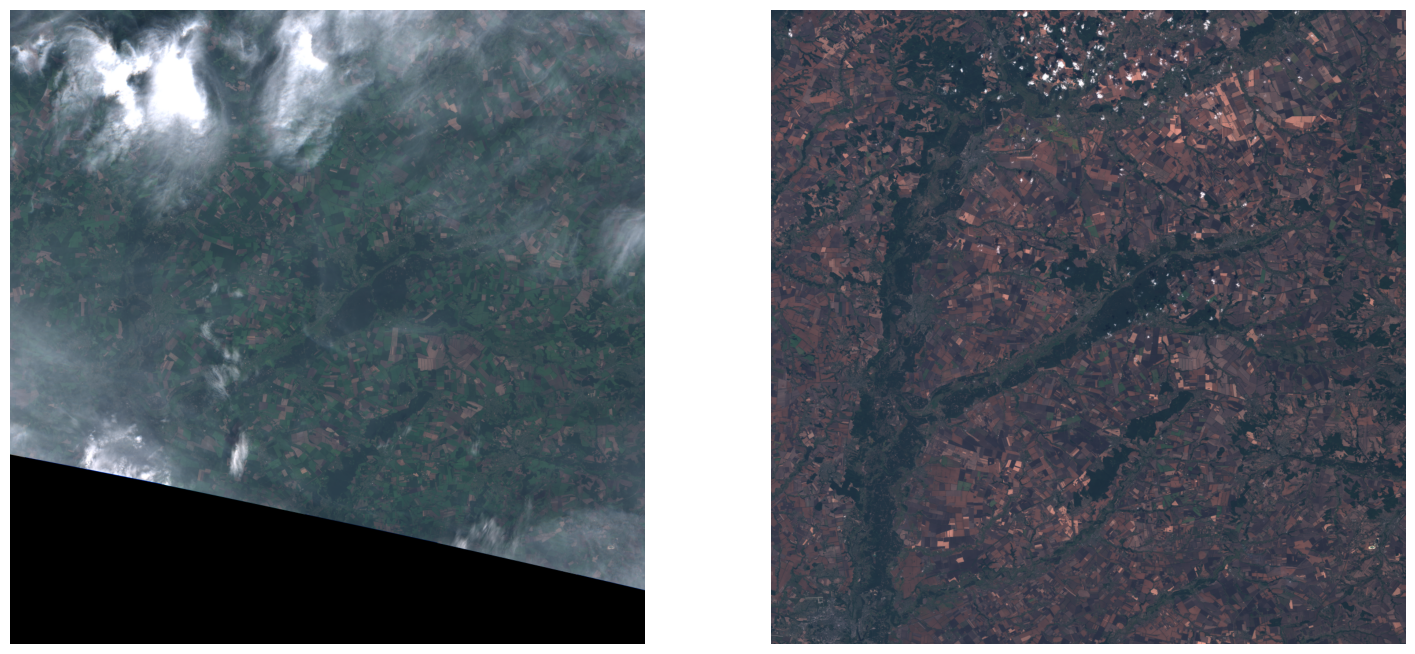

In [5]:
showImages(images)

Define matcher class

In [9]:
class Matcher:
    
    def __init__(self, image_size=None):
        self.image_size = image_size # Size of images for scaling
        self.matcher = K.feature.LoFTR(pretrained='outdoor') # Matcher itself
        
    def __call__(self, image0, image1, confidence_min=0.98, accurate=False):
        # Resize images
        image0 = self._convert_image(image0)
        image1 = self._convert_image(image1)

        # Convert images to greyscale
        input = {            
            'image0': K.color.rgb_to_grayscale(image0),
            'image1': K.color.rgb_to_grayscale(image1)
        } 
        # Get matching points       
        with torch.inference_mode():
            corresp = self.matcher(input)

        # Filter points by confidence
        mask = corresp['confidence'] > confidence_min
        indices = torch.nonzero(mask, as_tuple=True)               
        keypoints0 = corresp['keypoints0'][indices].cpu().numpy()
        keypoints1 = corresp['keypoints1'][indices].cpu().numpy()
        confidence = corresp['confidence'][indices].cpu().numpy()

        # Select inlier points relative to the fundamental matrix
        fmat_method = cv2.USAC_ACCURATE if accurate else cv2.USAC_MAGSAC
        try:
            fmat, inliers = cv2.findFundamentalMat(keypoints0, keypoints1, fmat_method, 1, 0.99, 100000)
            inliers = inliers > 0
        except:
            inliers = None        
        
        return {
            'image0' : image0,
            'image1' : image1,
            'keypoints0': keypoints0,
            'keypoints1': keypoints1,
            'confidence': confidence,
            'inliers': inliers
        }        

    # Draw points on corresponding keypoints in images    
    def draw_matches(match_dict):        
        output_fig = draw_LAF_matches(
            K.feature.laf_from_center_scale_ori(
                torch.from_numpy(match_dict['keypoints0']).view(1, -1, 2),
                torch.ones(match_dict['keypoints0'].shape[0]).view(1, -1, 1, 1),
                torch.ones(match_dict['keypoints0'].shape[0]).view(1, -1, 1),
            ),
            K.feature.laf_from_center_scale_ori(
                torch.from_numpy(match_dict['keypoints1']).view(1, -1, 2),
                torch.ones(match_dict['keypoints1'].shape[0]).view(1, -1, 1, 1),
                torch.ones(match_dict['keypoints1'].shape[0]).view(1, -1, 1),
            ),
            torch.arange(match_dict['keypoints0'].shape[0]).view(-1, 1).repeat(1, 2),
            K.tensor_to_image(match_dict['image0']),
            K.tensor_to_image(match_dict['image1']),
            match_dict['inliers'],
            draw_dict={
                'inlier_color': (0.2, 1, 0.2),
                'tentative_color': (1, 0.1, 0.1),
                'feature_color': (0.2, 0.5, 1),
                'vertical': False}
        )
        return output_fig   
    # Image resizing function
    def _convert_image(self, image):
        SIZE_MAX = 1280 
        image = K.utils.image_to_tensor(image)
        image = image.float().unsqueeze(dim=0) / 255.0
        if self.image_size:
            image = K.geometry.resize(image, self.image_size, interpolation='area')
        elif max(image.shape[-1], image.shape[-2]) > SIZE_MAX:
            image = K.geometry.resize(image, SIZE_MAX, side='long', interpolation='area')
        return image

In [10]:
matcherInst = Matcher((1024, 1024))


Calculate matching points of two images

In [11]:
corresp = matcherInst(images[0], images[1], 0.9, False)

Draw acquired matches

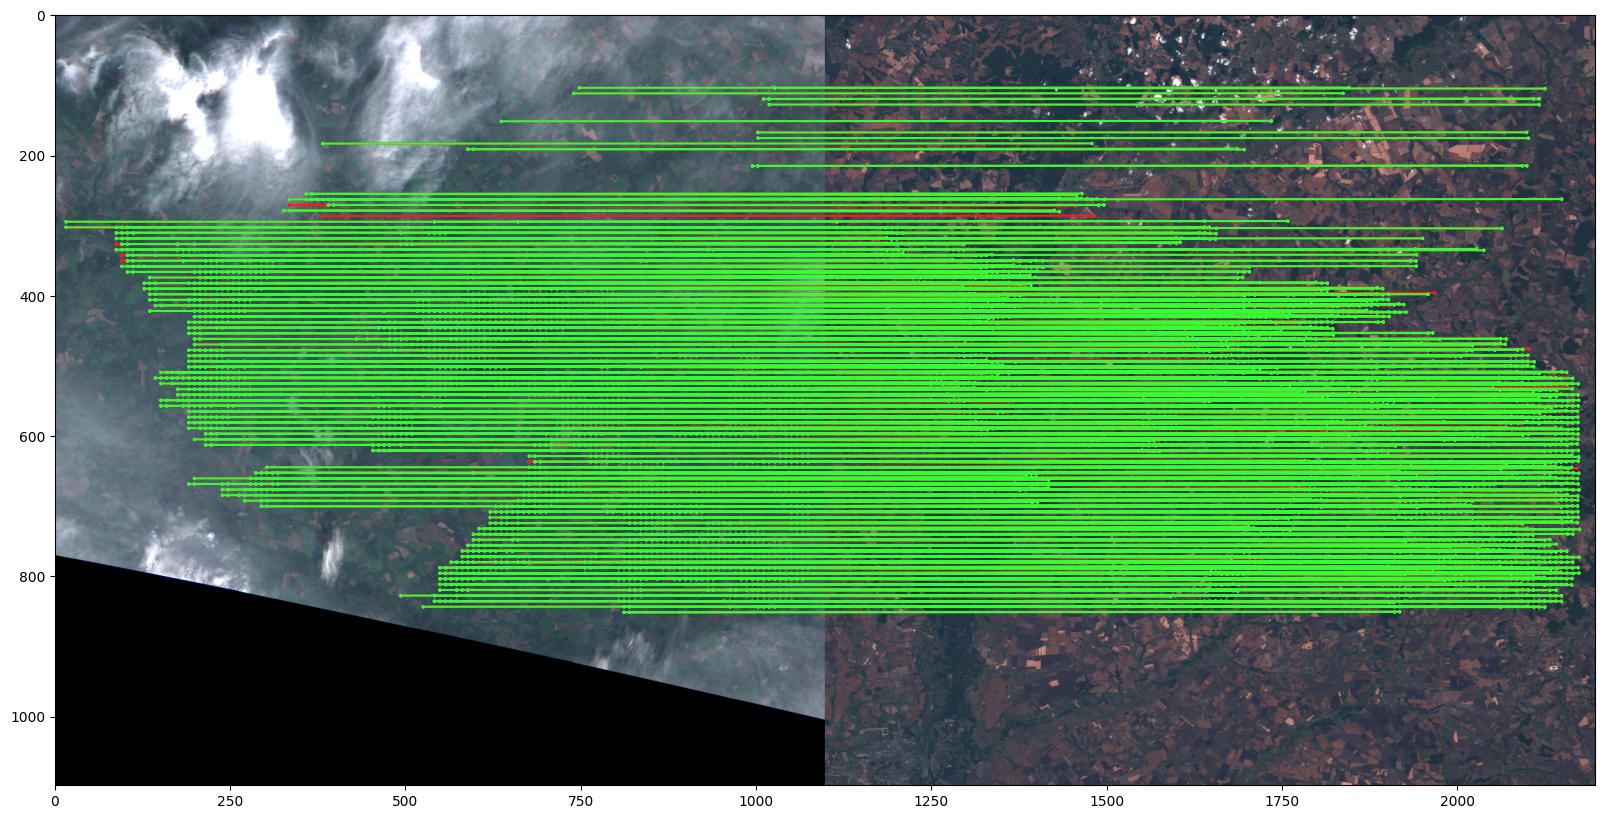

In [12]:
a=Matcher.draw_matches(corresp)
plt.show()